# 3d BCSD Crack inverse problem

In [1]:
import numpy as np
import sys
import os
np.set_printoptions(precision=5, suppress=True)
import matplotlib.pyplot as plt
from matplotlib import ticker, cm, colors
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [3.5, 3.5]
plt.rcParams['font.size'] = 15
plt.rcParams['text.usetex']=True
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.1
plt.rcParams["savefig.dpi"] = 100
plt.rcParams["text.latex.preamble"] =r'\usepackage{amsmath}'+ r'\usepackage{amssymb}' + r'\usepackage{accents}'+ r'\usepackage{bm}'+ r'\boldmath'+ r'\renewcommand{\v}[1]{\boldsymbol{{#1}}}'+ r'\DeclareRobustCommand{\sot}[1]{\boldsymbol{{#1}}}'

norm1 = lambda a : np.linalg.norm(a, axis=1)
norm = lambda a : np.linalg.norm(a)

from pathlib import Path
basefolder = "./data/"
Path(basefolder).mkdir(parents=True, exist_ok=True)

home = os.environ['HOME'] 
# sys.path.append(home + "/geolab/dev_bigwham/build/interfaces/python")
# from bigwham4py import Hmatrix  # linear operator file

sys.path.append(home + "/Desktop/GEL/BigWham/build/interfaces/python")
from hmatrix import Hmatrix  # linear operator file

In [2]:
h = 0.1
os.environ["OMP_NUM_THREADS"] = "4"

G = 1.0
nu = 0.25
E = (2 * G) * (1 + nu)
alpha = 1 - nu

tau_F = 1.0
sigma_A = (4*tau_F)/9

radius = 1.0
pz_fac = np.cos((np.pi*sigma_A)/(2*tau_F))
radius_ct = pz_fac*radius
pressure = 1.0

max_leaf_size = 16
eta = 3.0
eps_aca = 1e-3

#NEED TO REVISE THIS
pre_fac = (8 * (1 - nu * nu)) / (np.pi * E)

# Loading the mesh as per value of mesh
coord = np.load(basefolder + "mesh_coords_%s.npy"%(h))
conn = np.load(basefolder + "mesh_conn_%s.npy"%(h))

# Create H-matrix
kernel = "3DT0"
hmat = Hmatrix(kernel, coord, conn, np.array([E, nu]), max_leaf_size, eta, eps_aca)

# hmat.write_hmatrix(basefolder + "hmat_%s.h5"%(h))

col_pts = hmat.getMeshCollocationPoints()

 Now setting things for kernel ... 3DT0 with properties size 2
Cluster tree creation time :  0
Time for binary cluster tree construction  0.000479248
Binary cluster tree depth = 7
Number of blocks = 979
Number of full blocks = 401
Number of low rank blocks = 578
Pattern Created 
 Loop on full blocks construction  
 N full blocks 401 
Loop on low rank blocks construction
N low rank blocks 578
dof_dimension: 3
Creation of hmat done in 0.303855
Compression ratio - 0.579542
Hmat object - built 
HMAT --> built 
HMAT set, CR = 0.579542, eps_aca = 0.001, eta = 3
BigWhamIO ENDED


In [4]:
dd = np.zeros(col_pts.shape)

pzl2 = np.sqrt(radius**radius - radius_ct*radius_ct)
x_pzl2 = col_pts[:, :2]*pzl2
ctzl2 = np.sqrt(radius*radius - col_pts[:, :2]**2)
a_ctzl2 = radius_ct*ctzl2

dd[:, :2] = - pre_fac * (col_pts[:, :2]*np.log(abs((x_pzl2 + a_ctzl2)/(x_pzl2 - a_ctzl2))) - radius_ct*np.log(abs((pzl2 + ctzl2)/(pzl2 - ctzl2))))

# calculate tractions
t = hmat.matvec(dd.flatten())

t_anal = np.zeros(col_pts.shape)
t_anal[:, 2] = pressure

rel_err = np.linalg.norm(t - t_anal.flatten()) / t.shape[0]
print("L2 Rel error {}".format(rel_err))

L2 Rel error 0.21877013272964055


In [ ]:
trac = np.zeros(col_pts.shape)
trac[:, 1] = ct_pressure
for i in range(len(trac)):
    if abs(col_pts[i][0])>=a:
        trac[i][1] = pz_pressure
#print(trac)

u, info = gmres(hmat, hmat.convert_to_local(trac.flatten()))
dd_calc = hmat.convert_to_global(u)

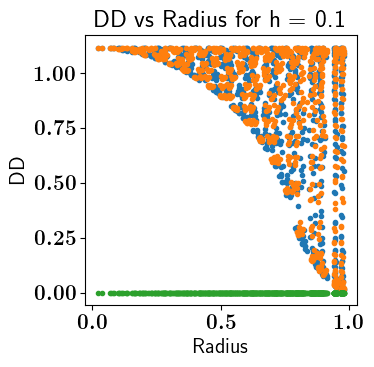

In [9]:
r = np.linalg.norm(col_pts[:, :2], axis=1)

plt.figure()
plt.plot(r, dd[:, :], ".")
plt.title("DD vs Radius for h = %s"%(h))
plt.xlabel("Radius")
plt.ylabel("DD")
plt.show()